In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential, load_model
from scipy.stats import pearsonr, spearmanr, ttest_1samp, ttest_ind_from_stats
import matplotlib.pyplot as plt
from matplotlib import rcParams
from seaborn import jointplot
rcParams.update({'figure.autolayout': True})
rcParams['svg.fonttype'] = 'none'
rcParams['font.size']=15

Using Theano backend.
Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'/tmp/try_flags_2lu9ucea.c:4:10: fatal error: cudnn.h: No such file or directory\n #include <cudnn.h>\n          ^~~~~~~~~\ncompilation terminated.\n'
ERROR (theano.gpuarray): Could not initialize pygpu, support disabled
Traceback (most recent call last):
  File "/home/eramamur/bin/miniconda3/envs/gpu_keras_theano/lib/python3.6/site-packages/theano/gpuarray/__init__.py", line 227, in <module>
    use(config.device)
  File "/home/eramamur/bin/miniconda3/envs/gpu_keras_theano/lib/python3.6/site-packages/theano/gpuarray/__init__.py", line 214, in use
    init_dev(device, preallocate=preallocate)
  File "/home/eramamur/bin/miniconda3/envs/gpu_keras_theano/lib/python3.6/site-packages/theano/gpuarray/__init__.py", line 140, in init_dev
    context.free_gmem / MB))
RuntimeError: Trying to preallocate 10619 MB of GPU memory while only 238 MB are available.


In [2]:
model_11_hg19 = load_model('/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_lcl/model_8_gc_matched_neg.hdf5', compile=False)

In [3]:
tewhey_ref_sequences = np.load("/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_lcl/tewhey_one_hot_encoded_ref_sequences.npy")
tewhey_alt_sequences = np.load("/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_lcl/tewhey_one_hot_encoded_alt_sequences.npy")

In [ ]:
ref_scores = model_11_hg19.predict(tewhey_ref_sequences)
alt_scores = model_11_hg19.predict(tewhey_alt_sequences)

In [2]:
ref_scores = np.load("dnase_regression_ref_scores.npy")
alt_scores = np.load("dnase_regression_alt_scores.npy")

In [3]:
tewhey_snp_info = pd.read_csv("/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_lcl/tewhey_snps_data_extended_joined_to_1kg_mappings_with_1kb_snp_centered_sequences_with_gm_overlaps.txt",
                              sep="\t")

In [4]:
tewhey_snp_info["Ref.score"] = ref_scores
tewhey_snp_info["Alt.score"] = alt_scores
tewhey_snp_info["Predicted.skew"] = tewhey_snp_info["Alt.score"] - tewhey_snp_info["Ref.score"]

             MPRA_log2FC  modelScores
MPRA_log2FC     1.000000     0.151151
modelScores     0.151151     1.000000
             MPRA_log2FC  modelScores
MPRA_log2FC     1.000000     0.209198
modelScores     0.209198     1.000000


/home/eramamur/bin/miniconda3/envs/gpu_keras_theano/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


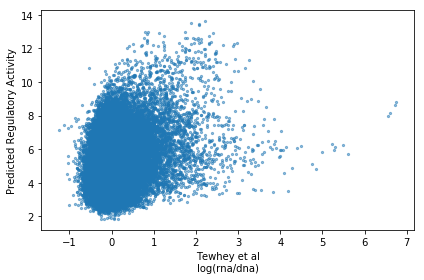

In [5]:
plt.scatter(tewhey_snp_info["C.B.log2FC"], tewhey_snp_info["Alt.score"], c='C0', s=5, alpha=0.5)
plt.scatter(tewhey_snp_info["C.A.log2FC"], tewhey_snp_info["Ref.score"], c='C0', s=5, alpha=0.5)
plt.xlabel("Tewhey et al\nlog(rna/dna)")
plt.ylabel("Predicted Regulatory Activity")
plt.savefig("dnase_regression_predicted_activity_vs_mpra_activity_scatter.svg")

corr_frame = pd.DataFrame({
                           "MPRA_log2FC":np.concatenate((np.array(tewhey_snp_info["C.A.log2FC"]),
                                                          np.array(tewhey_snp_info["C.B.log2FC"]))),
                           "modelScores":np.concatenate((np.array(np.log2(tewhey_snp_info["Ref.score"])),
                                                           np.array(np.log2(tewhey_snp_info["Alt.score"]))))
                           })

print(corr_frame.corr(method="spearman"))
print(corr_frame.corr(method="pearson"))

(0.11840899650654821, 3.629583775611183e-123)
SpearmanrResult(correlation=0.07760947700190356, pvalue=8.977462815243402e-54)


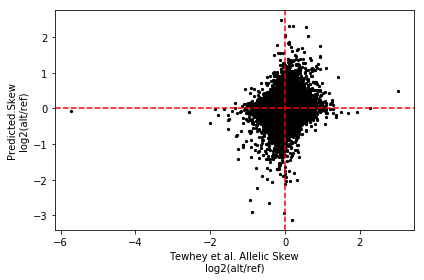

In [23]:
plt.scatter(tewhey_snp_info["LogSkew.Comb"],tewhey_snp_info["Predicted.skew"] , c = 'k', s=5)
plt.axhline(y=0, c='r', linestyle='--')
plt.axvline(x=0, c='r', linestyle='--')
plt.xlabel("Tewhey et al. Allelic Skew\nlog2(alt/ref)")
plt.ylabel("Predicted.Skew\nlog2(alt/ref)")
plt.savefig("skew_prediction_tewhey.svg")
print(pearsonr(np.nan_to_num(tewhey_snp_info["LogSkew.Comb"]), tewhey_snp_info["Predicted.skew"]))
print(spearmanr(np.nan_to_num(tewhey_snp_info["LogSkew.Comb"]), tewhey_snp_info["Predicted.skew"]))

(0.11840899650654821, 3.629583775611183e-123)
SpearmanrResult(correlation=0.07760947700190356, pvalue=8.977462815243402e-54)


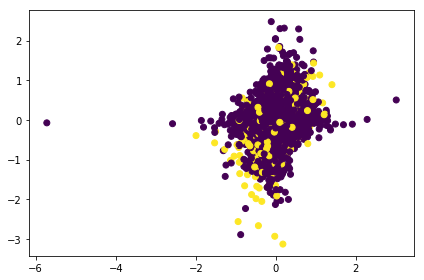

In [24]:
plt.scatter(tewhey_snp_info["LogSkew.Comb"], tewhey_snp_info["Predicted.skew"], c = tewhey_snp_info["Num.Overlaps.GM.peaks"]>0)
print(pearsonr(np.nan_to_num(tewhey_snp_info["LogSkew.Comb"]), tewhey_snp_info["Predicted.skew"]))
print(spearmanr(np.nan_to_num(tewhey_snp_info["LogSkew.Comb"]), tewhey_snp_info["Predicted.skew"]))

In [6]:
tewhey_snp_info_sig = tewhey_snp_info[tewhey_snp_info["C.Skew.fdr"] > -np.log10(0.05)]

x = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
y = []
for cutoff in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
    tewhey_snp_info_sig_cutoff = tewhey_snp_info_sig[np.absolute(tewhey_snp_info_sig["LogSkew.Comb"])>cutoff]
    num_correct = sum(np.sign(tewhey_snp_info_sig_cutoff["LogSkew.Comb"]) == np.sign(np.log2(tewhey_snp_info_sig_cutoff["Alt.score"]) - np.log2(tewhey_snp_info_sig_cutoff["Ref.score"])))
    num_wrong = sum(np.sign(tewhey_snp_info_sig_cutoff["LogSkew.Comb"]) != np.sign(np.log2(tewhey_snp_info_sig_cutoff["Alt.score"]) - np.log2(tewhey_snp_info_sig_cutoff["Ref.score"])))
    y.append(1*num_correct/(num_correct+num_wrong))

In [7]:
classifier_y = [0.6385302879841113, 0.6526429341963322, 0.6671105193075899, 0.6788321167883211, 0.6726342710997443, 0.6977611940298507, 0.7216494845360825, 0.765625, 0.776595744680851, 0.7592592592592593]

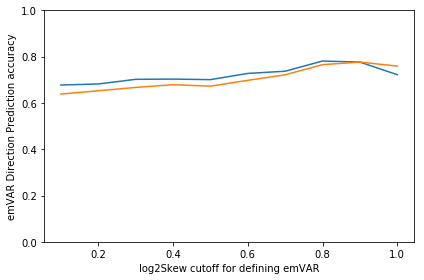

In [9]:
plt.plot(x,y)
plt.plot(x, classifier_y)
plt.ylabel("emVAR Direction Prediction accuracy")
plt.xlabel("log2Skew cutoff for defining emVAR")
plt.ylim([0,1])
plt.savefig("class_regression_comparison_accuracy.svg")

(0.4743983001390851, 2.455395691605731e-23)
SpearmanrResult(correlation=0.5210931195220564, pvalue=1.3334541178440316e-28)


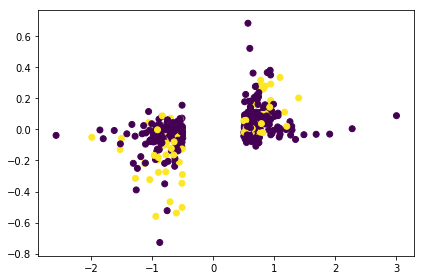

In [11]:
plt.scatter(tewhey_snp_info_sig["LogSkew.Comb"], tewhey_snp_info_sig["Predicted.skew"], c= tewhey_snp_info_sig["Num.Overlaps.GM.peaks"]>0)
print(pearsonr(np.nan_to_num(tewhey_snp_info_sig["LogSkew.Comb"]), tewhey_snp_info_sig["Predicted.skew"]))
print(spearmanr(np.nan_to_num(tewhey_snp_info_sig["LogSkew.Comb"]), tewhey_snp_info_sig["Predicted.skew"]))

In [11]:
tewhey_snp_info_pos = tewhey_snp_info[tewhey_snp_info["C.Skew.fdr"] > -np.log10(0.05)]
tewhey_snp_info_pos = tewhey_snp_info_pos[tewhey_snp_info_pos["LogSkew.Comb"]>0.5]

tewhey_snp_info_neg = tewhey_snp_info[tewhey_snp_info["C.Skew.fdr"] > -np.log10(0.05)]
tewhey_snp_info_neg = tewhey_snp_info_neg[tewhey_snp_info_neg["LogSkew.Comb"]< -0.5]


tewhey_snp_info_neutral = tewhey_snp_info[tewhey_snp_info["C.Skew.fdr"] < -np.log10(0.05)]
tewhey_snp_info_neutral = tewhey_snp_info_neutral[np.absolute(tewhey_snp_info_neutral["LogSkew.Comb"]) < 0.2]

Ttest_1sampResult(statistic=-7.279360106310908, pvalue=7.215635838774543e-12)
Ttest_1sampResult(statistic=1.7482701974220338, pvalue=0.08054389550022924)
Ttest_1sampResult(statistic=6.90335338453188, pvalue=7.766630760174716e-11)
Ttest_indResult(statistic=-7.465044669672185, pvalue=2.1737709502543387e-12)
Ttest_indResult(statistic=6.615528387448452, pvalue=3.543306927181801e-10)


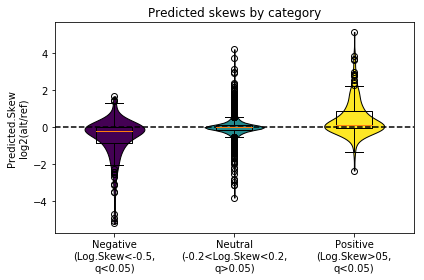

In [12]:
fig, ax = plt.subplots()

parts = ax.violinplot(dataset=[tewhey_snp_info_neg["Predicted.skew"].tolist(), tewhey_snp_info_neutral["Predicted.skew"].tolist(), tewhey_snp_info_pos["Predicted.skew"].tolist()],showmedians=False,showextrema=False)

parts['bodies'][0].set_facecolor('#440154FF')
parts['bodies'][0].set_edgecolor('black')
parts['bodies'][0].set_alpha(1)

parts['bodies'][1].set_facecolor('#238A8DFF')
parts['bodies'][1].set_edgecolor('black')
parts['bodies'][1].set_alpha(1)    


parts['bodies'][2].set_facecolor('#FDE725FF')
parts['bodies'][2].set_edgecolor('black')
parts['bodies'][2].set_alpha(1)   

plt.boxplot([tewhey_snp_info_neg["Predicted.skew"].tolist(), tewhey_snp_info_neutral["Predicted.skew"].tolist(), tewhey_snp_info_pos["Predicted.skew"].tolist()])
plt.axhline(y=0, c='k', linestyle='--')
plt.xticks(ticks = range(1,4), labels = ["Negative\n(Log.Skew<-0.5,\nq<0.05)", "Neutral\n(-0.2<Log.Skew<0.2,\nq>0.05)", "Positive\n(Log.Skew>05,\nq<0.05)"], horizontalalignment="center")
plt.ylabel("Predicted.Skew\nlog2(alt/ref)")
plt.title("Predicted skews by category")
plt.savefig("skew_prediction_categorized_tewhey.svg")
print(ttest_1samp(tewhey_snp_info_neg["Predicted.skew"].tolist(),0))
print(ttest_1samp(tewhey_snp_info_neutral["Predicted.skew"].tolist(),0))
print(ttest_1samp(tewhey_snp_info_pos["Predicted.skew"].tolist(),0))
print(ttest_ind_from_stats(np.mean(tewhey_snp_info_neg["Predicted.skew"]),
                     np.std(tewhey_snp_info_neg["Predicted.skew"]),
                     len(tewhey_snp_info_neg["Predicted.skew"].tolist()),
                     np.mean(tewhey_snp_info_neutral["Predicted.skew"]),
                     np.std(tewhey_snp_info_neutral["Predicted.skew"]),
                     len(tewhey_snp_info_neutral["Predicted.skew"].tolist()),
                     equal_var=False))
print(ttest_ind_from_stats(np.mean(tewhey_snp_info_pos["Predicted.skew"]),
                     np.std(tewhey_snp_info_pos["Predicted.skew"]),
                     len(tewhey_snp_info_pos["Predicted.skew"].tolist()),
                     np.mean(tewhey_snp_info_neutral["Predicted.skew"]),
                     np.std(tewhey_snp_info_neutral["Predicted.skew"]),
                     len(tewhey_snp_info_neutral["Predicted.skew"].tolist()),
                     equal_var=False))

In [13]:
tewhey_snp_info_overlapping_peaks = tewhey_snp_info[tewhey_snp_info["Num.Overlaps.GM.peaks"]>0]
tewhey_snp_info_pos = tewhey_snp_info_overlapping_peaks[tewhey_snp_info_overlapping_peaks["C.Skew.fdr"] > -np.log10(0.05)]
tewhey_snp_info_pos = tewhey_snp_info_pos[tewhey_snp_info_pos["LogSkew.Comb"]>0.5]

tewhey_snp_info_neg = tewhey_snp_info_overlapping_peaks[tewhey_snp_info_overlapping_peaks["C.Skew.fdr"] > -np.log10(0.05)]
tewhey_snp_info_neg = tewhey_snp_info_neg[tewhey_snp_info_neg["LogSkew.Comb"]< -0.5]


tewhey_snp_info_neutral = tewhey_snp_info_overlapping_peaks[tewhey_snp_info_overlapping_peaks["C.Skew.fdr"] < -np.log10(0.05)]
tewhey_snp_info_neutral = tewhey_snp_info_neutral[np.absolute(tewhey_snp_info_neutral["LogSkew.Comb"]) < 0.2]

Ttest_1sampResult(statistic=-6.407091993541917, pvalue=4.357538653939815e-08)
Ttest_1sampResult(statistic=3.120698916298962, pvalue=0.0019046391144984008)
Ttest_1sampResult(statistic=4.9589405093737, pvalue=1.6013291511124346e-05)
Ttest_indResult(statistic=-6.828355989204273, pvalue=7.884184767414704e-09)
Ttest_indResult(statistic=4.533887885326848, pvalue=5.497597307136434e-05)


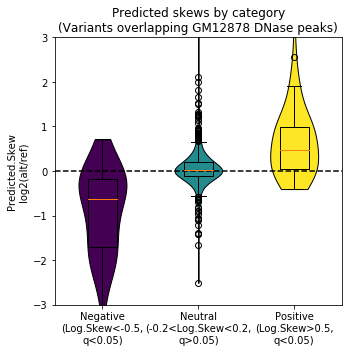

In [14]:
fig, ax = plt.subplots(figsize=(5,5))

parts = ax.violinplot(dataset=[tewhey_snp_info_neg["Predicted.skew"].tolist(), tewhey_snp_info_neutral["Predicted.skew"].tolist(), tewhey_snp_info_pos["Predicted.skew"].tolist()],showmedians=False,showextrema=False)

parts['bodies'][0].set_facecolor('#440154FF')
parts['bodies'][0].set_edgecolor('black')
parts['bodies'][0].set_alpha(1)

parts['bodies'][1].set_facecolor('#238A8DFF')
parts['bodies'][1].set_edgecolor('black')
parts['bodies'][1].set_alpha(1)    


parts['bodies'][2].set_facecolor('#FDE725FF')
parts['bodies'][2].set_edgecolor('black')
parts['bodies'][2].set_alpha(1)   

plt.boxplot([tewhey_snp_info_neg["Predicted.skew"].tolist(), tewhey_snp_info_neutral["Predicted.skew"].tolist(), tewhey_snp_info_pos["Predicted.skew"].tolist()])
plt.axhline(y=0, c='k', linestyle='--')
plt.xticks(ticks = range(1,4), labels = ["Negative\n(Log.Skew<-0.5,\nq<0.05)", "Neutral\n(-0.2<Log.Skew<0.2,\nq>0.05)", "Positive\n(Log.Skew>0.5,\nq<0.05)"], horizontalalignment="center")
plt.ylabel("Predicted.Skew\nlog2(alt/ref)")
plt.title("Predicted skews by category\n(Variants overlapping GM12878 DNase peaks)")
plt.ylim([-3,3])
plt.savefig("dnase_regression_skew_prediction_tewhey_categorized_peaks_only.svg")
print(ttest_1samp(tewhey_snp_info_neg["Predicted.skew"].tolist(),0))
print(ttest_1samp(tewhey_snp_info_neutral["Predicted.skew"].tolist(),0))
print(ttest_1samp(tewhey_snp_info_pos["Predicted.skew"].tolist(),0))
print(ttest_ind_from_stats(np.mean(tewhey_snp_info_neg["Predicted.skew"]),
                     np.std(tewhey_snp_info_neg["Predicted.skew"]),
                     len(tewhey_snp_info_neg["Predicted.skew"].tolist()),
                     np.mean(tewhey_snp_info_neutral["Predicted.skew"]),
                     np.std(tewhey_snp_info_neutral["Predicted.skew"]),
                     len(tewhey_snp_info_neutral["Predicted.skew"].tolist()),
                     equal_var=False))
print(ttest_ind_from_stats(np.mean(tewhey_snp_info_pos["Predicted.skew"]),
                     np.std(tewhey_snp_info_pos["Predicted.skew"]),
                     len(tewhey_snp_info_pos["Predicted.skew"].tolist()),
                     np.mean(tewhey_snp_info_neutral["Predicted.skew"]),
                     np.std(tewhey_snp_info_neutral["Predicted.skew"]),
                     len(tewhey_snp_info_neutral["Predicted.skew"].tolist()),
                     equal_var=False))

In [4]:
#X_train = np.load('/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_lcl/chrs_training_summit_centered_training_set_hg19_X.npy')
#Y_train = np.load('/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_lcl/chrs_training_summit_centered_training_set_hg19_Y.npy')
X_valid = np.load('/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_lcl/chr4_summit_centered_validation_set_hg19_X.npy')
Y_valid = np.load('/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_lcl/chr4_summit_centered_validation_set_hg19_Y.npy')

In [4]:
#pred_train = model_11_hg19.predict(X_train)
pred_valid = model_11_hg19.predict(X_valid)

Training: (array([0.75791571]), array([0.]))
Training: SpearmanrResult(correlation=0.7674512528330918, pvalue=0.0)


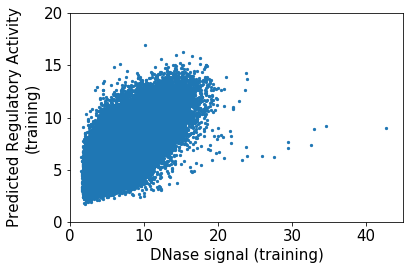

In [187]:
plt.scatter(Y_train, pred_train, s=5)
plt.xlabel("DNase signal (training)")
plt.ylabel("Predicted Regulatory Activity\n(training)")
plt.xlim([0,45])
plt.ylim([0,20])

plt.savefig("gm_model_training_chr_prediction.svg")

print("Training:",pearsonr(Y_train, pred_train))
print("Training:",spearmanr(Y_train, pred_train))


Validation: (array([0.6884696]), array([0.]))
Validation: SpearmanrResult(correlation=0.6987954068549386, pvalue=0.0)


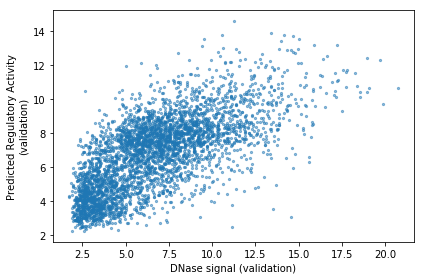

In [6]:
plt.scatter(Y_valid, pred_valid, s=5, alpha=0.5)
plt.xlabel("DNase signal (validation)")
plt.ylabel("Predicted Regulatory Activity\n(validation)")


plt.savefig("dnase_regression_valid_scatter.png")

print("Validation:",pearsonr(Y_valid, pred_valid))
print("Validation:",spearmanr(Y_valid, pred_valid))